In [ ]:
 #@title Modules

import re
from typing import Dict, List, Optional, Text, Tuple
import os
import time
from time import sleep
from tqdm import tqdm, trange
from scipy.ndimage import zoom

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
import cv2

import tensorflow as tf
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from torchvision import datasets, models, transforms
import torchvision.models
from torchvision.transforms.functional import F_pil

In [ ]:
#@title Mount Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data Helper Functions

In [ ]:
#@title File Path

train_00_path = '/content/drive/MyDrive/Colab Notebooks/APS360 Project/next_day_wildfire_spread_train_00.tfrecord'
train_01_path = '/content/drive/MyDrive/Colab Notebooks/APS360 Project/next_day_wildfire_spread_train_01.tfrecord'
train_02_path = '/content/drive/MyDrive/Colab Notebooks/APS360 Project/next_day_wildfire_spread_train_02.tfrecord'
train_03_path = '/content/drive/MyDrive/Colab Notebooks/APS360 Project/next_day_wildfire_spread_train_03.tfrecord'
train_04_path = '/content/drive/MyDrive/Colab Notebooks/APS360 Project/next_day_wildfire_spread_train_04.tfrecord'
train_05_path = '/content/drive/MyDrive/Colab Notebooks/APS360 Project/next_day_wildfire_spread_train_05.tfrecord'
train_06_path = '/content/drive/MyDrive/Colab Notebooks/APS360 Project/next_day_wildfire_spread_train_06.tfrecord'

val_00_path = '/content/drive/MyDrive/Colab Notebooks/APS360 Project/next_day_wildfire_spread_eval_00.tfrecord'

test_02_path = '/content/drive/MyDrive/Colab Notebooks/APS360 Project/next_day_wildfire_spread_test_02.tfrecord'

In [ ]:
test_unseen_01_path = '/content/drive/MyDrive/Colab Notebooks/APS360 Project/next_day_wildfire_spread_test_unseen_01.tfrecord'
test_unseen_02_path = '/content/drive/MyDrive/Colab Notebooks/APS360 Project/next_day_wildfire_spread_test_unseen_02.tfrecord'
test_unseen_03_path = '/content/drive/MyDrive/Colab Notebooks/APS360 Project/next_day_wildfire_spread_test_unseen_03.tfrecord'

In [ ]:
#@title Data Information & Statistic

"""Constants for the data reader."""

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask', ]

# Data statistics
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, standard deviation)
DATA_STATS = {
    # Elevation in m.
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),

    # Drought Index (Palmer Drought Severity Index)
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),

    #Vegetation index (times 10,000 maybe, since it's supposed to be b/w -1 and 1?)
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),  # min, max

    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.53038024902344, 1.7398051, 4.482833),

    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'sph': (0., 1., 0.0071658953, 0.0042835088),

    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.32976, 72.59854),

    # Min/max temperature in Kelvin.

    #Min temp
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.94891357421875, 281.08768, 8.982386),

    #Max temp
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.09228515625, 295.17383, 9.815496),

    # Wind speed in m/s.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.024310074806237, 3.8500874, 1.4109988),

    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.24891662597656, 37.326267, 20.846027),

    # Population density
    # min, 99.9 percentile
    'population': (0., 2534.06298828125, 25.531384, 154.72331),

    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

In [ ]:
#@title Cropping function & Data Reader

"""Library of common functions used in deep learning neural networks.
"""
#YOU PROBABLY WILL NOT USE THESE.

def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Randomly axis-align crop input and output image tensors.

  Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
    num_in_channels: number of channels in input_img.
    num_out_channels: number of channels in output_img.
  Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
  """
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Center crops input and output image tensors.

  Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
  Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
  """
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img

"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
  """Extracts the base key from the provided key.

  Earth Engine exports TFRecords containing each data variable with its
  corresponding variable name. In the case of time sequences, the name of the
  data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
  where 'variable' is the name of the variable, and n the number of elements
  in the time sequence. Extracting the base key ensures that each step of the
  time sequence goes through the same normalization steps.
  The base key obeys the following naming pattern: '([a-zA-Z]+)'
  For instance, for an input key 'variable_1', this function returns 'variable'.
  For an input key 'variable', this function simply returns 'variable'.

  Args:
    key: Input key.

  Returns:
    The corresponding base key.

  Raises:
    ValueError when `key` does not match the expected pattern.
  """
  match = re.match(r'([a-zA-Z]+)', key)
  if match:
    return match.group(1)
  raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and rescales inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and rescale.
    key: Key describing the inputs.

  Returns:
    Clipped and rescaled input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and normalizes inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and normalize.
    key: Key describing the inputs.

  Returns:
    Clipped and normalized input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  """Creates a features dictionary for TensorFlow IO.

  Args:
    sample_size: Size of the input tiles (square).
    features: List of feature names.

  Returns:
    A features dictionary for TensorFlow IO.
  """
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Reads a serialized example.

  Args:
    example_proto: A TensorFlow example protobuf.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    num_in_channels: Number of input channels.
    clip_and_normalize: True if the data should be clipped and normalized.
    clip_and_rescale: True if the data should be clipped and rescaled.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data should be cropped in the center.

  Returns:
    (input_img, output_img) tuple of inputs and outputs to the ML model.
  """
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]

  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)
  return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  """Gets the dataset from the file pattern.

  Args:
    file_pattern: Input file pattern.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    batch_size: Batch size.
    num_in_channels: Number of input channels.
    compression_type: Type of compression used for the input files.
    clip_and_normalize: True if the data should be clipped and normalized, False
      otherwise.
    clip_and_rescale: True if the data should be clipped and rescaled, False
      otherwise.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data shoulde be cropped in the center.

  Returns:
    A TensorFlow dataset loaded from the input file pattern, with features
    described in the constants, and with the shapes determined from the input
    parameters to this function.
  """
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(file_pattern)
  dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      lambda x: _parse_fn(  # pylint: disable=g-long-lambda
          x, data_size, sample_size, num_in_channels, clip_and_normalize,
          clip_and_rescale, random_crop, center_crop),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
#@title Avg Neighbors

#Eventually would like a function that takes in an input array of dimensions nxn,
#outputs an array that gives avg of each cell's neighbors:
def avg_neighbors(array_in):
    #Check input
    if array_in.shape[0] != array_in.shape[1]:
        raise Exception('Only square arrays make sense here, since you\'re analyzing square arrays.')
    #Maybe should also do type-checking, but leave it for now.

    #Prepare the output array:
    n = array_in.shape[0]
    array_out = np.zeros((n,n))

    #Guess who doesn't know how to do signal processing in Python...

    for i in range(n):
        for j in range(n):
            if i == 0:
                #Upper edge
                if j == 0:
                    #Upper left corner
                    sum_neighbors = array_in[i+1, j] + array_in[i, j+1] + array_in[i+1, j+1]
                    avg = sum_neighbors/3

                elif j == (n-1):
                    #Upper right corner
                    sum_neighbors = array_in[i, j-1] + array_in[i+1, j] + array_in[i+1, j-1]
                    avg = sum_neighbors/3

                else:
                    #Upper edge except corners
                    sum_neighbors = array_in[i, j-1] + array_in[i+1, j] + array_in[i, j+1] + array_in[i+1, j-1] + array_in[i+1, j+1]
                    avg = sum_neighbors/5

            elif i == (n-1):
                #Lower edge
                if j == 0:
                    #Lower left corner
                    sum_neighbors = array_in[i-1, j] + array_in[i, j+1] + array_in[i-1, j+1]
                    avg = sum_neighbors/3

                elif j == (n-1):
                    #Lower right corner
                    sum_neighbors = array_in[i, j-1] + array_in[i-1, j] + array_in[i-1, j-1]
                    avg = sum_neighbors/3

                else:
                    #Lower edge except corners
                    sum_neighbors = array_in[i, j-1] + array_in[i, j+1] + array_in[i-1, j] + array_in[i-1, j-1] + array_in[i-1, j+1]
                    avg = sum_neighbors/5

            else:
                if j == 0:
                    #Left edge except corners
                    sum_neighbors = array_in[i-1, j] + array_in[i+1, j] + array_in[i, j+1] + array_in[i-1, j+1] + array_in[i+1, j+1]
                    avg = sum_neighbors/5

                elif j == (n-1):
                    #Right edge except corners
                    sum_neighbors = array_in[i-1, j] + array_in[i+1, j] + array_in[i, j-1] + array_in[i-1, j-1] + array_in[i+1, j-1]
                    avg = sum_neighbors/5

                else:
                    #Not on any edge or corner
                    sum_neighbors = array_in[i, j+1] + array_in[i, j-1] + array_in[i-1, j] + array_in[i+1, j] + \
                                    array_in[i-1, j-1] + array_in[i-1, j+1] + array_in[i+1, j-1] + array_in[i+1, j+1]
                    avg = sum_neighbors/8


            array_out[i,j] = avg
            #/for loop body

    return array_out

In [ ]:
#@title Elim_Uncertain, Extract Certain Label, Avg Neighbors in Batch

#Function to identify certain observations in the previous fire mask and return:
#1) a list of their indices in the batch (need this to grab the right ones from the labels) and
#2) the actual array of certain observations

def elim_uncertain(prev_fire_mask_batch):

    prev_masks_array = np.array(prev_fire_mask_batch)
    num_imgs, rows, cols = prev_masks_array.shape

    #Build the array of certain data AND SAVE THE INDICES
    first_find_flag = 1
    count = 0
    indices = []

    for img_num in range(num_imgs):
        fire_mask = prev_fire_mask_batch[img_num, :, :] #grab the "working fire mask" off the pile

        if (np.all( np.invert(fire_mask == -1) )): #If no missing data, condition is TRUE.
            count += 1
            indices.append(img_num)
            if first_find_flag == 1: #If you need to start the array
                certain_prev_fire_masks_batch = fire_mask
                first_find_flag = 0  #Remember to turn the flag off!
            else:
                certain_prev_fire_masks_batch = np.dstack((certain_prev_fire_masks_batch, fire_mask))

    return certain_prev_fire_masks_batch, indices

#Function to extract only the labels (i.e. current fire masks) from the certain observations
def extract_certain_labels(certain_indices, og_labels):

    for i, index in enumerate(certain_indices):
        if i == 0:
            extracted_labels = og_labels[index,:,:,:] #the og_labels dimensions are batch_size by sidelength by sidelength by 1
        else:
            #labels
            extracted_labels = np.concatenate((extracted_labels, og_labels[index,:,:,:]), axis=2)

    return extracted_labels

#Create multi-D array of neighbor fire values
def avg_neighbor_batch(batch_in):
    rows, cols, batch_size = batch_in.shape #ordering of dimensions here meant to be compatible with elim_uncertain and extract_certain_labels
    batch_out = np.zeros((rows, cols, batch_size))
    for i in range(batch_size):
        working_arr = batch_in[:,:,i]
        avgd_arr = avg_neighbors(working_arr)
        batch_out[:,:,i] =  avgd_arr
    #/for loop

    return batch_out

In [ ]:
#@title extract_data

def extract_data(file_path, batch_num, image_dim=64, cropping=False, average_neighbors=False):
  '''
  input:
    file_path, path of tfrecord
    batch_num, batch size
    image_dim, image dimensiion; at most 64
    cropping, whether or not to crop
    average_neighbors, whether or not to average the fire

  takes in the input with specified task, pass it through functions that eliminates uncertainties

  Output:
    good_prev_masks, array of relevent prev fire masks
    good_labels, array of labels corresponding to the relevent prevfire masks
    good_indices, indices of relvent fire masks in the batch
    inputs, all features of the dataset

  '''
  dataset = get_dataset(
      file_path,
      data_size=64,
      sample_size=image_dim,
      batch_size=batch_num,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=cropping,
      center_crop=False)

  inputs, labels = next(iter(dataset))
  # inputs.shape --> (batch_size, img_dim, img_dim, feature_col)
  # labels.shape --> (batch_size, img_dim, img_dim, 1)

  all_prev_fire_masks = np.array(inputs[:,:,:,11]) # shape --> (batch_size, img_dim, img_dim)
  all_curr_fire_masks = np.array(labels)

  good_prev_masks, good_indices = elim_uncertain(all_prev_fire_masks)
  # good_prev_masks.shape --> (img_dim, img_dim, batch_size)
  # good_indices, a list of the index of good prev fire masks, indexed base on batch number

  good_labels = extract_certain_labels(good_indices, all_curr_fire_masks)
  # good_labels.shape --> (img_dim, img_dim, batch_size)
  # good prev fire masks' corresponding label, compiled in an array

  if average_neighbors: # if average_neighbors is set to true, average function will run
    good_prev_masks = avg_neighbor_batch(good_prev_masks)
    # outputs retains the same shape as input but pixels are average

  return good_prev_masks, good_labels, good_indices, inputs


## Load and Save TFRecord Data as JPG Data

In [ ]:
#@title Combine good masks, label with their other corresponding features

# location on Google Drive
master_path = '/content/drive/MyDrive/Colab Notebooks/APS360 Project'

# Load data
batch_size = 1 #want to save 1 file at a time -> batch_size = 1

#convert tfrecord file into 1 big array of only good data
def add_to_array(data_path):
    prev_masks, good_labels, good_indices, all_inputs = extract_data(data_path, 100)
    all_inputs = np.array(all_inputs)
    for i in range(len(good_indices)):
        prev_mask = prev_masks[:,:,i] #get the single prev_mask in the correct order
        prev_mask = prev_mask[..., np.newaxis] #convert prev_mask to 3D array
        good_label = good_labels[:,:,i] #get the single good_label in the correct order
        good_label = good_label[..., np.newaxis] #convert good_label to 3D array
        last_two_labels = np.concatenate((prev_mask, good_label), axis=2) #combine prev_mask and good_label into 1 array

        if i == 0:
          big_arr = np.concatenate((all_inputs[good_indices[i], :, :, 0:11], last_two_labels), axis=2) #store as first array in big_arr
          big_arr = big_arr[np.newaxis, ...] #
        else:
          new_arr = np.concatenate((all_inputs[good_indices[i], :, :, 0:11], last_two_labels), axis=2) #add to first array
          new_arr = new_arr[np.newaxis, ...]
          big_arr = np.concatenate((big_arr, new_arr), axis=0)
    return big_arr

In [ ]:
#@title Testing the code above
data_path = train_00_path
prev_masks, good_labels, good_indices, all_inputs = extract_data(data_path, 100)
all_inputs = np.array(all_inputs)
print(prev_masks[:,:,0].shape)
print(all_inputs[good_indices[0], :, :, 0:11].shape)
var = prev_masks[:,:,1]
var = var[..., np.newaxis]
var.shape
prev_mask = prev_masks[:,:,0] #get the single prev_mask in the correct order
prev_mask = prev_mask[..., np.newaxis] #convert prev_mask to 3D array
good_label = good_labels[:,:,0] #get the single good_label in the correct order
good_label = good_label[..., np.newaxis] #convert good_label to 3D array
last_two_labels = np.concatenate((prev_mask, good_label), axis=2) #combine prev_mask and good_label into 1 array
print(last_two_labels.shape)
big_arr = np.concatenate((all_inputs[good_indices[0], :, :, 0:11], last_two_labels), axis=2) #store as first array in big_arr
big_arr = big_arr[np.newaxis, ...]
new_arr = np.concatenate((all_inputs[good_indices[1], :, :, 0:11], last_two_labels), axis=2) #add to first array
new_arr = new_arr[np.newaxis, ...]
big_arr = np.concatenate((big_arr, new_arr), axis=0)
big_arr.shape
big_arr.shape[0]

(64, 64)
(64, 64, 11)
(64, 64, 2)


2

In [ ]:
#@title Forming np array of all training data
train_arr1 = add_to_array(train_00_path)
train_arr2 = add_to_array(train_01_path)
train_arr3 = add_to_array(train_02_path)
train_arr4 = add_to_array(train_03_path)
train_arr5 = add_to_array(train_04_path)
train_arr6 = add_to_array(train_05_path)
train_arr7 = add_to_array(train_06_path)
whole_train_arr = np.concatenate((train_arr1, train_arr2), axis=0)
whole_train_arr = np.concatenate((whole_train_arr, train_arr3), axis=0)
whole_train_arr = np.concatenate((whole_train_arr, train_arr4), axis=0)
whole_train_arr = np.concatenate((whole_train_arr, train_arr5), axis=0)
whole_train_arr = np.concatenate((whole_train_arr, train_arr6), axis=0)
whole_train_arr = np.concatenate((whole_train_arr, train_arr7), axis=0)
print(whole_train_arr.shape)

#forming np array of val data
val_arr = add_to_array(val_00_path)
print(val_arr.shape)

(483, 64, 64, 13)
(73, 64, 64, 13)


In [ ]:
#forming np array of all test data
test_unseen_arr1 = add_to_array(test_unseen_01_path)
test_unseen_arr2 = add_to_array(test_unseen_02_path)
test_unseen_arr3 = add_to_array(test_unseen_03_path)
test_unseen_arr4 = add_to_array(test_02_path)
whole_test_unseen_arr = np.concatenate((test_unseen_arr1, test_unseen_arr2), axis=0)
whole_test_unseen_arr = np.concatenate((whole_test_unseen_arr, test_unseen_arr3), axis=0)
whole_test_unseen_arr = np.concatenate((whole_test_unseen_arr, test_unseen_arr4), axis=0)

In [ ]:
print(whole_test_unseen_arr.shape)

(295, 64, 64, 13)


In [ ]:
#@title Upscaling and Saving Images to Folder
def features_to_folder(set_name, folder_path, data_arr):
    for n in range(data_arr.shape[0]):
      for i in range(data_arr.shape[3]):
        #save each feature to respective data folder with the right name
        folder_name = folder_path + "/Input" + '/' + set_name + '/data_' + str(n)
        if not os.path.isdir(folder_name):
          os.mkdir(folder_name)

        upscaled_img = zoom(whole_train_arr[n,:,:,i], 3.5, order=0)

        if i <= 10: #if is not a mask feature, save w cmap = 'viridis'
              plt.imsave(folder_name + '/feature_' + str(i) + '.jpg', upscaled_img, cmap = 'viridis')
        elif i == 11: #else hv to save mask as rgb img
              CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
              BOUNDS = [-1, -0.1, 0.001, 1]
              NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
              plt.imsave(folder_name + '/feature_' + str(i) + '.jpg', upscaled_img, cmap=CMAP)
        elif i == 12: #else if it's the label, save as rgb img w/ name "label"
              #label_img = whole_train_arr[n,:,:,i]
              CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
              BOUNDS = [-1, -0.1, 0.001, 1]
              NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
              plt.imsave(folder_name + '/label.jpg', upscaled_img, cmap=CMAP)

In [ ]:
features_to_folder("train", master_path, whole_train_arr)
features_to_folder("val", master_path, val_arr)
#features_to_folder("test", master_path, test_arr)

In [ ]:
features_to_folder("test_unseen", master_path, whole_test_unseen_arr)

## Clean gray

In [ ]:
def preclean_input_loader(purpose):

  output = []

  folder_path = '/content/drive/MyDrive/Colab Notebooks/APS360 Project/Input'
  folder_path = folder_path + '/' + purpose
  data_dir = os.listdir(folder_path)

  for i in range(len(data_dir)):
    data_path = os.path.join(folder_path, data_dir[i])
    feature_dir = os.listdir(data_path)

    data = []
    label = []

    for j in range(len(feature_dir)):
      feature_path = os.path.join(data_path, feature_dir[j])

      print(feature_path)

      if j == 11:
          data = Image.open(feature_path)
          data = np.array(data)

      elif j == 12:
          label_path = feature_path
          label = Image.open(label_path)
          label = np.array(label)

    output.append((data, label))

  return output

In [ ]:
preclean_train = preclean_input_loader('train')
preclean_val = preclean_input_loader('val')
#preclean_test = preclean_input_loader('test')

In [ ]:
preclean_test_unseen = preclean_input_loader('test_unseen')

In [ ]:
#Function:
#for data, label in each folder
#find images with gray pixels (192, 192, 192)
#if either data or label contains gray pixels, os.remove the corresponding folder

def clean_grey(data_loader, set_name):
  count = 0
  num = 0
  folder_path = '/content/drive/MyDrive/Colab Notebooks/APS360 Project/Input'
  for data, label in data_loader:
    if ([192, 192, 192] in data) or ([192, 192, 192] in label):
      data_grey = np.count_nonzero(data==192)
      label_grey = np.count_nonzero(label==192)
      if (data_grey>50) or (label_grey>50):
        print("File", count, "data_grey:", data_grey, "label_grey:", label_grey)
        grey_direct = folder_path + '/' + set_name + '/data_' + str(count)

        for root, dirs, files in os.walk(grey_direct):
        # For each file in the directory
          for file in files:
            # Construct the full path to the file
            file_path = os.path.join(root, file)
            # Delete the file
            os.remove(file_path)
            # For each subdirectory in the directory
          for dir in dirs:
            # Construct the full path to the subdirectory
            dir_path = os.path.join(root, dir)
            # Delete the subdirectory
            os.rmdir(dir_path)
        # Delete the top-level directory
        os.rmdir(grey_direct)

        num += 1
    count += 1
  print("Number of file with grey pixels:", num)

In [ ]:
clean_grey(preclean_train, 'train')
clean_grey(preclean_val, 'val')
#clean_grey(preclean_test, 'test')

File 11 data_grey: 4 label_grey: 147579
File 16 data_grey: 0 label_grey: 142157
File 18 data_grey: 0 label_grey: 143389
File 40 data_grey: 0 label_grey: 141449
File 57 data_grey: 0 label_grey: 148678
File 67 data_grey: 1 label_grey: 129017
File 75 data_grey: 0 label_grey: 148393
File 76 data_grey: 1 label_grey: 142226
File 79 data_grey: 1 label_grey: 144768
File 83 data_grey: 2 label_grey: 135293
File 87 data_grey: 0 label_grey: 144248
File 101 data_grey: 2 label_grey: 140036
File 103 data_grey: 1 label_grey: 144712
File 110 data_grey: 0 label_grey: 142628
File 122 data_grey: 1 label_grey: 112381
File 129 data_grey: 0 label_grey: 136535
File 132 data_grey: 4 label_grey: 132414
File 134 data_grey: 1 label_grey: 140372
File 135 data_grey: 0 label_grey: 143880
File 136 data_grey: 5 label_grey: 141581
File 137 data_grey: 0 label_grey: 138225
File 138 data_grey: 2 label_grey: 142153
File 141 data_grey: 0 label_grey: 144772
File 145 data_grey: 0 label_grey: 144965
File 147 data_grey: 1 label

In [ ]:
clean_grey(preclean_test_unseen, 'test_unseen')

File 11 data_grey: 4 label_grey: 147579
File 16 data_grey: 0 label_grey: 142157
File 18 data_grey: 0 label_grey: 143389
File 40 data_grey: 0 label_grey: 141449
File 57 data_grey: 0 label_grey: 148678
File 67 data_grey: 1 label_grey: 129017
File 75 data_grey: 0 label_grey: 148393
File 76 data_grey: 1 label_grey: 142226
File 79 data_grey: 1 label_grey: 144768
File 83 data_grey: 2 label_grey: 135293
File 87 data_grey: 0 label_grey: 144248
File 101 data_grey: 2 label_grey: 140036
File 103 data_grey: 1 label_grey: 144712
File 110 data_grey: 0 label_grey: 142628
File 122 data_grey: 1 label_grey: 112381
File 129 data_grey: 0 label_grey: 136535
File 132 data_grey: 4 label_grey: 132414
File 134 data_grey: 1 label_grey: 140372
File 135 data_grey: 0 label_grey: 143880
File 136 data_grey: 5 label_grey: 141581
File 137 data_grey: 0 label_grey: 138225
File 138 data_grey: 2 label_grey: 142153
File 141 data_grey: 0 label_grey: 144772
File 145 data_grey: 0 label_grey: 144965
File 147 data_grey: 1 label

## Eliminate duplicates

In [ ]:
eliminateD_train_unseen = preclean_input_loader('train')
eliminateD_test_unseen = preclean_input_loader('test_unseen')

In [ ]:
def eliminate_duplicate(train_loader, test_loader, train_name, test_name):
  count = 0
  num = 0
  folder_path = '/content/drive/MyDrive/Colab Notebooks/APS360 Project/Input'
  for data, label in test_loader:
    test_data = data
    for data1, label1 in train_loader:
      train_data = data1
      if np.array_equal(test_data, train_data):
        dup_direct = folder_path + '/' + test_name + '/data_' + str(count)
        if os.path.exists(dup_direct):
          for root, dirs, files in os.walk(dup_direct):
          # For each file in the directory
            for file in files:
              # Construct the full path to the file
              file_path = os.path.join(root, file)
              # Delete the file
              os.remove(file_path)
              # For each subdirectory in the directory
            for dir in dirs:
              # Construct the full path to the subdirectory
              dir_path = os.path.join(root, dir)
              # Delete the subdirectory
              os.rmdir(dir_path)
          # Delete the top-level directory
          os.rmdir(dup_direct)

          num += 1
    count += 1
  print("Number of files that are duplicates:", num)

In [ ]:
eliminate_duplicate(eliminateD_train_unseen, eliminateD_test_unseen, 'train', 'test_unseen')

In [ ]:
unseen_test = '/content/drive/MyDrive/Colab Notebooks/APS360 Project/Input/test_unseen'
data_dir = os.listdir(unseen_test)
print(len(data_dir))

38


## Transfer Learning

In [ ]:
#@title Pathing
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 86.6MB/s]


In [ ]:
data_path = master_path + '/Input/train'

#testing later code
data_path
item_dir = os.listdir(data_path)
print(item_dir)
for d in range(len(item_dir)):
  data_path2 = os.path.join(data_path, item_dir[d])
  feature_path = os.listdir(data_path2)
  #print(data_path)
print(feature_path)
print(feature_path[0][:-4])
feature_path[12] == 'label.jpg'

['data_0', 'data_1', 'data_2', 'data_3', 'data_4', 'data_5', 'data_6', 'data_7', 'data_8', 'data_9', 'data_10', 'data_12', 'data_13', 'data_14', 'data_15', 'data_17', 'data_19', 'data_20', 'data_21', 'data_22', 'data_23', 'data_24', 'data_25', 'data_26', 'data_27', 'data_28', 'data_29', 'data_30', 'data_31', 'data_32', 'data_33', 'data_34', 'data_35', 'data_36', 'data_37', 'data_38', 'data_39', 'data_41', 'data_42', 'data_43', 'data_44', 'data_45', 'data_46', 'data_47', 'data_48', 'data_49', 'data_50', 'data_51', 'data_52', 'data_53', 'data_54', 'data_55', 'data_56', 'data_58', 'data_59', 'data_60', 'data_61', 'data_62', 'data_63', 'data_64', 'data_65', 'data_66', 'data_68', 'data_69', 'data_70', 'data_71', 'data_72', 'data_73', 'data_74', 'data_77', 'data_78', 'data_80', 'data_81', 'data_82', 'data_84', 'data_85', 'data_86', 'data_88', 'data_89', 'data_90', 'data_91', 'data_92', 'data_93', 'data_94', 'data_95', 'data_96', 'data_97', 'data_98', 'data_99', 'data_100', 'data_102', 'data_

True

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/APS360 Project/Input/train/data_0/label.jpg'
img = Image.open(path)
trans_img = np.transpose(img, (2, 1, 0))
img_tensor1 = torch.Tensor(trans_img)
print(img_tensor1.shape)
exp_trans_img = trans_img[np.newaxis, ...]
img_tensor = torch.Tensor(trans_img)
alexnet_feats = alexnet.features(img_tensor)
feats_tensor = torch.from_numpy(alexnet_feats.detach().numpy())
feats_tensor.shape
sq = feats_tensor.squeeze(0)
sq.shape

torch.Size([3, 224, 224])


torch.Size([256, 6, 6])

In [ ]:
#@title Save alexnet features for each image to folders
def alexnet_features_to_folder(set_name, folder_path):
    input_path = folder_path + '/Input'
    data_path = os.path.join(input_path, set_name)
    data_dir = os.listdir(data_path)
    for d in data_dir:
        #print(d)
        data_path1 = os.path.join(data_path, d)
        #print(data_path1)
        feat_dir = os.listdir(data_path1)
        #save each feature to folder with the right name
        folder_name = folder_path + "/Output" + '/' + set_name + '/' + d
        if not os.path.isdir(folder_name):
            os.mkdir(folder_name)
        #print(feat_dir)
        for f in feat_dir:
            feat_path = os.path.join(data_path1, f)
            img = Image.open(feat_path)
            #transpose img to 3x224x224
            trans_img = np.transpose(img, (2, 1, 0))
            if f != 'label.jpg': #if feature is not the label
              exp_trans_img = trans_img[np.newaxis, ...] #convert to 1x3x244x244
              #convert img np array to tensor
              img_tensor = torch.Tensor(exp_trans_img)
              alexnet_feats = alexnet.features(img_tensor)
              feats_tensor = torch.from_numpy(alexnet_feats.detach().numpy())
              torch.save(feats_tensor.squeeze(0), folder_name + '/' + f[:-4] + '.tensor')
            else: #if it is the label, just save the transposed img + don't pass to alexnet
              img_tensor = torch.Tensor(exp_trans_img)
              torch.save(img_tensor, folder_name + '/' + f[:-4] + '.tensor')

'''
1. extract dataset -> prev_masks, good_labels, good_indices, all_input
2. concatentate all good features into 1 array:
  a. index all inputs with good indices, all_inputs(good_indices[0])
3. Outer loop = batch_num
4. Inner loop = feature
5. Use os to iterate thru the folder
'''

'\n1. extract dataset -> prev_masks, good_labels, good_indices, all_input\n2. concatentate all good features into 1 array:\n  a. index all inputs with good indices, all_inputs(good_indices[0])\n3. Outer loop = batch_num\n4. Inner loop = feature\n5. Use os to iterate thru the folder\n'

In [ ]:
alexnet_features_to_folder("train", master_path)
alexnet_features_to_folder("val", master_path)
alexnet_features_to_folder("test", master_path)

In [ ]:
alexnet_features_to_folder("test_unseen", master_path)

<ipython-input-59-45dfdac2bc4f>:24: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img_tensor = torch.Tensor(exp_trans_img)


## Neural Network

In [ ]:
#@title Load Data

def load_embedding(purpose):

  output = []

  folder_path = '/content/drive/MyDrive/Colab Notebooks/APS360 Project/Output'
  folder_path = folder_path + '/' + purpose
  data_dir = os.listdir(folder_path)

  for i in range(len(data_dir)):
    data_path = os.path.join(folder_path, data_dir[i])
    feature_dir = os.listdir(data_path)

    data = []
    label = []

    for j in range(len(feature_dir)):
      feature_path = os.path.join(data_path, feature_dir[j])

      print(feature_path)

      if j == 0:
          data = torch.load(feature_path)
          data = data.view(-1, 9216)
          data = data[np.newaxis, ...]
      elif j >= 1 and j <= 11:
          feature = torch.load(feature_path)
          feature = feature.view(-1, 9216)
          feature = feature[np.newaxis, ...]
          data = np.concatenate((data, feature), axis=0)
      elif j == 12:
          label_path = feature_path[:54] + 'Input/' +feature_path[61:-6] + 'jpg'
          label = Image.open(label_path)
          label = np.array(label)
          label = torch.from_numpy(label)

    output.append((data, label))

  return output

In [ ]:
training_data = load_embedding('train')
val_data = load_embedding('val')
test_data = load_embedding('test')

In [ ]:
test_unseen_data = load_embedding('test_unseen')

/content/drive/MyDrive/Colab Notebooks/APS360 Project/Output/test_unseen/data_242/feature_0.tensor
/content/drive/MyDrive/Colab Notebooks/APS360 Project/Output/test_unseen/data_242/feature_1.tensor
/content/drive/MyDrive/Colab Notebooks/APS360 Project/Output/test_unseen/data_242/feature_2.tensor
/content/drive/MyDrive/Colab Notebooks/APS360 Project/Output/test_unseen/data_242/feature_3.tensor
/content/drive/MyDrive/Colab Notebooks/APS360 Project/Output/test_unseen/data_242/feature_4.tensor
/content/drive/MyDrive/Colab Notebooks/APS360 Project/Output/test_unseen/data_242/feature_5.tensor
/content/drive/MyDrive/Colab Notebooks/APS360 Project/Output/test_unseen/data_242/feature_6.tensor
/content/drive/MyDrive/Colab Notebooks/APS360 Project/Output/test_unseen/data_242/feature_7.tensor
/content/drive/MyDrive/Colab Notebooks/APS360 Project/Output/test_unseen/data_242/feature_8.tensor
/content/drive/MyDrive/Colab Notebooks/APS360 Project/Output/test_unseen/data_242/feature_9.tensor
/content/d

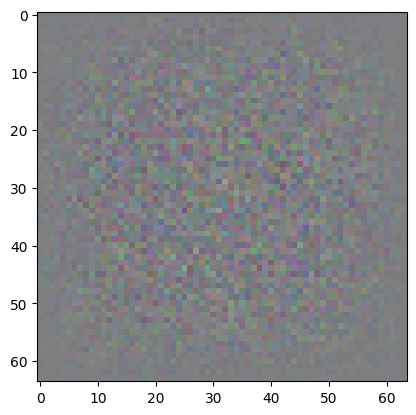

In [ ]:
model1 = FirePrediction()
out = model1.forward(training_data[9][0])
out = np.transpose(out[0,:,:,:],(1,2,0))
plt.imshow(out)
plt.show()

In [ ]:
torch.save(training_data, '/content/drive/MyDrive/Colab Notebooks/APS360 Project/loaded_training.npy')
torch.save(val_data, '/content/drive/MyDrive/Colab Notebooks/APS360 Project/loaded_val.npy')
torch.save(test_data, '/content/drive/MyDrive/Colab Notebooks/APS360 Project/loaded_test.npy')

In [ ]:
torch.save(test_unseen_data, '/content/drive/MyDrive/Colab Notebooks/APS360 Project/loaded_test_unseen.npy')

In [ ]:
training_data = torch.load('/content/drive/MyDrive/Colab Notebooks/APS360 Project/loaded_training.npy')
val_data = torch.load('/content/drive/MyDrive/Colab Notebooks/APS360 Project/loaded_val.npy')
test_data = torch.load('/content/drive/MyDrive/Colab Notebooks/APS360 Project/loaded_test.npy')

In [ ]:
test_data = torch.load('/content/drive/MyDrive/Colab Notebooks/APS360 Project/loaded_test_unseen.npy')

In [ ]:
#@title Load from Offline
training_data = torch.load('loaded_training.npy')
val_data = torch.load('loaded_val.npy')
test_data = torch.load('loaded_test.npy')

In [ ]:
#@title Neural Network

class FirePrediction(nn.Module):

  def __init__(self):
    self.name = 'FirePrediction'
    super(FirePrediction, self).__init__()
    self.rnn = nn.GRU(9216, 9216, 1) #512, 256 smaller hidden size
    kernel_size = 4
    stride = 2
    padding = 1
    out_padding = 0
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(256, 128, 4, stride, padding, out_padding),
        nn.ConvTranspose2d(128, 64, 9, stride, padding, out_padding),
        nn.ConvTranspose2d(64, 3, 10, stride, padding, out_padding),
    )

  def forward(self, x):
    x = np.array(x)

    if len(x.shape) ==  2:
      print(True)
      x = np.expand_dims(x, axis=1)

    rnn_input = torch.from_numpy(x[0:10, :, :])
    h0 = x[11,:,:]
    h0 = torch.from_numpy(h0[np.newaxis, ...])

    out, h = self.rnn(rnn_input, h0)

    output_array = []

    for i in range(h.shape[1]):
      decoder_input = h[:,i,:]
      decoder_input = decoder_input[0,:]
      decoder_input = torch.reshape(decoder_input, (256, 6, 6))
      decoder_input = decoder_input[np.newaxis, ...]
      output = self.decoder(decoder_input)
      output = F.relu(output)

      if i == 0:
        output_array = output
      else:
        output_array = torch.cat((output_array, output), 0)

    return output_array

In [ ]:
class UpsampleFirePrediction(nn.Module):

    def __init__(self):
        self.name = 'UpsampleFirePrediction'
        super(UpsampleFirePrediction, self).__init__()
        self.rnn = nn.GRU(9216, 9216, 1) #512, 256 smaller hidden size
        kernel_size = 4
        stride = 2
        padding = 1
        out_padding = 0
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride, padding, out_padding),
            nn.Upsample(scale_factor=1.75, mode='bilinear'),
            nn.ConvTranspose2d(128, 64, 2, stride, padding, out_padding),
            nn.Upsample(scale_factor=1.75, mode='bilinear'),
            nn.ConvTranspose2d(64, 3, 4, stride, padding, out_padding),
            nn.Upsample(scale_factor=2, mode='bilinear')
        )

    def forward(self, x):
        x = np.array(x)

        if len(x.shape) ==  2:
          print(True)
          x = np.expand_dims(x, axis=1)

        rnn_input = torch.from_numpy(x[0:10, :, :])
        h0 = x[11,:,:]
        h0 = torch.from_numpy(h0[np.newaxis, ...])

        out, h = self.rnn(rnn_input, h0)

        output_array = []

        for i in range(h.shape[1]):
            decoder_input = h[:,i,:]
            decoder_input = decoder_input[0,:]
            decoder_input = torch.reshape(decoder_input, (256, 6, 6))
            decoder_input = decoder_input[np.newaxis, ...]
            output = self.decoder(decoder_input)
            output = F.relu(output)

            if i == 0:
                output_array = output
            else:
                output_array = torch.cat((output_array, output), 0)

        return output_array

## Training

In [ ]:
def drop_last(batch_size, data_loader):
    output = data_loader
    counter = 1

    if batch_size > len(output):
        batch_size = len(output)

    while len(output) % batch_size != 0:
        output = output[:-counter]
        counter += 1

    return output

def concat_batch(batch_size, data_loader):
    batched_set = []
    for i in range(0, len(data_loader), batch_size):
        batched_data = []
        batched_label = []
        for j in range(0, batch_size, 1):
            if j == 0:
                batched_data = data_loader[i][0]
                label = data_loader[i][1]
                label = Image.fromarray(np.array(label))
                label = label.resize((64, 64))
                label = np.array(label)
                batched_label = label[np.newaxis, ...]
            else:
                batched_data = np.concatenate((batched_data, data_loader[j+i][0]), axis=1)
                label = data_loader[j+i][1]
                label = Image.fromarray(np.array(label))
                label = label.resize((64, 64))
                label = np.array(label)
                batched_label = np.concatenate((batched_label, label[np.newaxis, ...]), axis=0)
            print('batch data shape', batched_data.shape)
            print('batch label shape', batched_label.shape)
        batched_set.append((batched_data, batched_label))
        if i+j == len(data_loader)-1:
            break

    return batched_set

def get_accuracy(model, data_loader, use_cuda=True):
    accuracies = []
    counter = 0

    for features, labels in tqdm(data_loader, desc='Accuracy', unit='batch'):
        recon = model(features)
        recon = torch.transpose(recon, 1, 2) #give 0 3 1 3
        recon = torch.transpose(recon, 2, 3) # give 0 2 3 1
        difference = np.array(recon) - np.array(label)
        squared_difference = np.square(difference)
        mse = np.mean(squared_difference)/(255**2)
        accuracies.append(mse)
        counter += 1

    sigma = 0
    for item in accuracies:
        sigma += item
        #print('sigma is', sigma, 'number of error calculated is', counter, 'the average is', float(sigma)/float(counter))

    acc_sum = float(sigma)
    item_num = int(counter)

    number = (acc_sum, item_num)

    return number[1]/number[0]

def get_model_name(name, learning_rate, epoch):
    path = "model_{0}_lr{1}_epoch{2}".format(name, learning_rate, epoch)
    return path

def get_val_loss(model, valid_loader, criterion):
    total_val_loss = 0.0
    i = 0

    for data,label in tqdm(valid_loader, desc='Loss', unit='batch'):
        recon = model(data)

        #0 1 2 3
        recon = torch.transpose(recon, 1, 2) #give 0 3 1 3
        recon = torch.transpose(recon, 2, 3) # give 0 2 3 1
        loss = criterion(recon, label.float())
        loss.requires_grad=True
        total_val_loss += loss.item()
        i += 1
    val_loss = float(total_val_loss)/i
    return val_loss

def train(model, train_loader, valid_loader, batch_size=90, num_epochs=5, learning_rate=1e-4, use_cuda=True):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    print('I am loading data into loader')
    train_loader = drop_last(batch_size, train_loader)
    train_loader = concat_batch(batch_size, train_loader)
    valid_loader = drop_last(batch_size, valid_loader)
    valid_loader = concat_batch(batch_size, valid_loader)

    start_time = time.time()
    for epoch in tqdm(range(num_epochs), desc='Epoch', unit='epoch'):
        total_train_loss = 0.0
        i = 0
        for data,label in tqdm(train_loader, desc='Training', unit='batch'):
            label = torch.from_numpy(label)

            '''
            #############################################
            # To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                data = data.cuda()
                label = label.cuda()
            #############################################
            '''
            recon = model(data)

            #0 1 2 3
            recon = torch.transpose(recon, 1, 2) #give 0 3 1 3
            recon = torch.transpose(recon, 2, 3) # give 0 2 3 1
            '''
            recon = torch.from_numpy(recon).detach()
            label = torch.from_numpy(label).detach()
            '''
            optimizer.zero_grad()
            #print('recon size', recon.size)
            #print('label size', label.size, 'label type is', type(label))
            loss = criterion(recon, label.float())
            #loss.requires_grad=True
            total_train_loss += loss.item()
            i += 1
            loss.backward()
            optimizer.step()

        print('Calculating epoch', epoch, 'training error')
        train_err[epoch] = get_accuracy(model, train_loader)

        print('Calculating epoch', epoch, 'training loss')
        train_loss[epoch] = float(total_train_loss)/(i + 1)
        #print('The shape of train_loader[1][0]:', train_loader[1][0].shape)
        #print('The shape of valid_loader[1][0]:', valid_loader[1][0].shape)

        print('Calculating epoch', epoch, 'validation error')
        val_err[epoch] = get_accuracy(model, valid_loader)

        print('Calculating epoch', epoch, 'validation loss')
        val_loss[epoch] = get_val_loss(model, valid_loader, criterion)
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Plotting
    plt.title("Train vs Validation Loss")
    plt.plot(range(1 ,num_epochs+1), train_loss, label="Train")
    plt.plot(range(1 ,num_epochs+1), val_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(range(1 ,num_epochs+1), train_err, label="Train")
    plt.plot(range(1 ,num_epochs+1), val_err, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_err[-1]))
    print("Final Validation Accuracy: {}".format(val_err[-1]))

In [ ]:
train_loader = drop_last(90, training_data)
train_loader = concat_batch(90, train_loader)

batch data shape (12, 1, 9216)
batch label shape (1, 64, 64, 3)
batch data shape (12, 2, 9216)
batch label shape (2, 64, 64, 3)
batch data shape (12, 3, 9216)
batch label shape (3, 64, 64, 3)
batch data shape (12, 4, 9216)
batch label shape (4, 64, 64, 3)
batch data shape (12, 5, 9216)
batch label shape (5, 64, 64, 3)
batch data shape (12, 6, 9216)
batch label shape (6, 64, 64, 3)
batch data shape (12, 7, 9216)
batch label shape (7, 64, 64, 3)
batch data shape (12, 8, 9216)
batch label shape (8, 64, 64, 3)
batch data shape (12, 9, 9216)
batch label shape (9, 64, 64, 3)
batch data shape (12, 10, 9216)
batch label shape (10, 64, 64, 3)
batch data shape (12, 11, 9216)
batch label shape (11, 64, 64, 3)
batch data shape (12, 12, 9216)
batch label shape (12, 64, 64, 3)
batch data shape (12, 13, 9216)
batch label shape (13, 64, 64, 3)
batch data shape (12, 14, 9216)
batch label shape (14, 64, 64, 3)
batch data shape (12, 15, 9216)
batch label shape (15, 64, 64, 3)
batch data shape (12, 16, 92

In [ ]:
print(len(train_loader))
print(len(train_loader[0]))
print(train_loader[0][0].shape)
print(train_loader[0][1].shape)

3
2
(12, 90, 9216)
(90, 64, 64, 3)


In [ ]:
print('Calculating epoch', epoch, 'training error')

In [ ]:
model = FirePrediction()
train(model, training_data, val_data)

I am loading data into loader


Training:   0%|          | 0/269 [00:00<?, ?batch/s]

In [ ]:
print(model.rnn.weight.grad)

In [ ]:
path2 = '/content/model_FirePrediction_lr0.0001_epoch1'
net2 = torch.load(path2)
net2

In [ ]:
path = '/content/model_FirePrediction_lr0.0001_epoch2'
net = torch.load(path)
net

In [ ]:
model_5 = UpsampleFirePrediction()
train(model_5, train_data, val_data, num_epochs=300, batch_size=128, learning_rate=0.0001)

In [ ]:
# Function to view predictions
def image_viewer(image_array):
    if len(image_array.shape) == 4:
        image_array = image_array[0,:,:,:]
        image_array = np.array(image_array.detach().numpy())
        image_array = np.transpose(image_array, (1, 2, 0))
    elif len(image_array.shape) == 3:
        image_array = np.array(image_array.detach().numpy())
        #image_array = np.transpose(image_array, (0, =))
    else:
        raise Typererror('Incorrect dimension')

    plt.imshow(image_array)
    plt.show()
    return

In [ ]:
# Checking the unseen test data results
for i in range(len(test_unseen_data)):
    print('-----' + str(i) +'th testing data' + '-----')
    output = model_5(test_unseen_data[i][0])
    label = test_unseen_data[i][1]
    image_viewer(output)
    image_viewer(label)
    if i > len(test_unseen_data):
        break

# Baseline



In [ ]:
#@title Load Input for Baseline

def baseline_input_loader(purpose):

  output = []

  folder_path = '/content/drive/MyDrive/Colab Notebooks/APS360 Project/Input'
  folder_path = folder_path + '/' + purpose
  data_dir = os.listdir(folder_path)

  for i in range(len(data_dir)):
    data_path = os.path.join(folder_path, data_dir[i])
    feature_dir =  os.listdir(data_path)

    data = []
    label = []

    for j in range(len(feature_dir)):
      feature_path = os.path.join(data_path, feature_dir[j])

      print(feature_path)

      if j == 11:
          data = Image.open(feature_path)
          data = np.array(data)
          '''
          elif j >= 1 and j <= 11:
              feature = torch.load(feature_path)
              feature = feature.view(-1, 9216)
              feature = feature[np.newaxis, ...]
              data = np.concatenate((data, feature), axis=0)
          '''
      elif j == 12:
          #label_path = feature_path[:54] + 'Input/' +feature_path[61:-6] + 'jpg'
          label_path = feature_path
          label = Image.open(label_path)
          label = np.array(label)

    output.append((data, label))

  return output

In [ ]:
training_baseline = baseline_input_loader('train')
val_baseline = baseline_input_loader('val')
testing_baseline = baseline_input_loader('test')

In [ ]:
test_unseen_baseline = baseline_input_loader('test_unseen')

In [ ]:
len(training_baseline)

393

In [ ]:
def avg_red(dataset):
  red = 0
  count = 0
  for data, label in dataset:
    red += np.count_nonzero(data == 255)
    count += 1

  return red/count

def pred_correct(data, label, average):
  red_data = np.count_nonzero(data == 255)
  red_label = np.count_nonzero(label == 255)
  if (red_data < average) and (red_label < red_data):
      return True
  elif (red_data > average) and (red_label > red_data):
      return True
  elif (red_data == average) and (red_label == red_data):
      return True
  else:
      return False

In [ ]:
prediction = []
average_red = avg_red(training_baseline)
for data, label in training_baseline:
    pred = pred_correct(data, label, average_red)
    prediction.append(pred)

print("Number of correct predictions:", sum(prediction))
print("Number of incorrect predictions:", len(prediction)-sum(prediction))

print("The training accuracy of our baseline model is", sum(prediction)/len(prediction))

Number of correct predictions: 131
Number of incorrect predictions: 262
The training accuracy of our baseline model is 0.3333333333333333


In [ ]:
prediction = []
average_red = avg_red(val_baseline)
for data, label in val_baseline:
    pred = pred_correct(data, label, average_red)
    prediction.append(pred)

print("Number of correct predictions:", sum(prediction))
print("Number of incorrect predictions:", len(prediction)-sum(prediction))

print("The validation accuracy of our baseline model is", sum(prediction)/len(prediction))

Number of correct predictions: 23
Number of incorrect predictions: 44
The validation accuracy of our baseline model is 0.34328358208955223


In [ ]:
prediction = []
average_red = avg_red(testing_baseline)
for data, label in testing_baseline:
    pred = pred_correct(data, label, average_red)
    prediction.append(pred)

print("Number of correct predictions:", sum(prediction))
print("Number of incorrect predictions:", len(prediction)-sum(prediction))

print("The test accuracy of our baseline model is", sum(prediction)/len(prediction))

Number of correct predictions: 13
Number of incorrect predictions: 49
The test accuracy of our baseline model is 0.20967741935483872


In [ ]:
prediction = []
average_red = avg_red(test_unseen_baseline)
for data, label in test_unseen_baseline:
    pred = pred_correct(data, label, average_red)
    prediction.append(pred)

print("Number of correct predictions:", sum(prediction))
print("Number of incorrect predictions:", len(prediction)-sum(prediction))

print("The accuracy of our baseline model on an unseen test dataset is", sum(prediction)/len(prediction))

Number of correct predictions: 28
Number of incorrect predictions: 43
The accuracy of our baseline model on an unseen test dataset is 0.39436619718309857
